
![](https://hsto.org/files/256/a5d/ed0/256a5ded03274e0f87ccf97164c31c35.png)


# Регрессия - моя профессия


Задача, где надо спрогнозировать непрерывную переменную называется регрессией. Пример непрерывной переменной: цена на квартиры. Именно её прогнозированием мы сегодня и займёмся. Поехали!


## 1. Предобработка данных 

Начнём наш крестовый поход за дешёвой недвижимостью с предобработки данных. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже знакомый вам пакет для картинок 
import seaborn as sns             # ещё один пакет для картинок 

%matplotlib inline

In [4]:
df = pd.read_csv('data/flat.csv', sep='\t', index_col='n')  # подгружаем табличку 
print('Размер выборки:', df.shape)                          # смотрим на её размеры 
df.head( ) # Смотрим что лежит в табличке 

Размер выборки: (2040, 10)


,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


__Описание переменных:__

```
n – номер квартиры по порядку
price – цена квартиры в $1000
totsp – общая площадь квартиры, кв.м.
livesp жилая площадь квартиры, кв.м.
kitsp – площадь кухни, кв.м.
dist – расстояние от центра в км.
metrdist – расстояние до метро в минутах
walk – 1 – пешком от метро, 0 – на транспорте
brick 1 – кирпичный, монолит ж/б, 0 – другой
floor 1 – этаж кроме первого и последнего, 0 – иначе.
code – число от 1 до 8, при помощи которого мы группируем наблюдения по
подвыборкам:
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии
метрополитена
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
3. Северо-запад, вокруг Замоскворецкой линии метрополитена
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
5. Юго-восток, вокруг Люблинской линии метрополитена
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
7. Восток, вокруг Калиниской линии метрополитена
8. Восток, вокруг Арбатско-Покровской линии метрополитена
```


Какие переменный категориальные? Какие непрерывные?

In [5]:
df.info() # Аосмотрим на информацию по типам переменных 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
price       2040 non-null int64
totsp       2040 non-null int64
livesp      2040 non-null int64
kitsp       2040 non-null float64
dist        2040 non-null float64
metrdist    2040 non-null int64
walk        2040 non-null int64
brick       2040 non-null int64
floor       2040 non-null int64
code        2040 non-null int64
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


In [6]:
df.isnull().sum()  # посмотрим на то есть ли в переменных пропуски

price       0
totsp       0
livesp      0
kitsp       0
dist        0
metrdist    0
walk        0
brick       0
floor       0
code        0
dtype: int64

Пропусков нет. Это хорошая новость. А что делать, если бы они были? Вспоминайте, что мы делали в прошлый раз с Титаником! 

Посмотрим как выглядит распределение цен. 

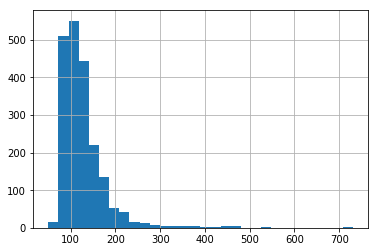

In [7]:
df.price.hist(bins=30);

У распределения цен есть проблема - очень длинный хвост. В выборке встречаются квартиры с довольно большой стоимостью. Такие наблюдения называются выбросами. С ними нужно бороться, иначе наша модель подстроится под них. Давайте сгладим распределение цен, прологарифмировав его. Так довольно часто поступают с целевой переменной. 

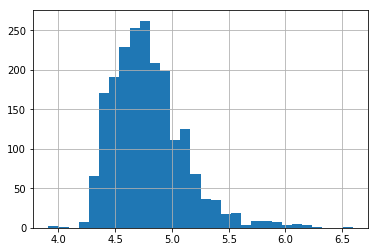

In [8]:
df['price'] = np.log(df['price'])
df.price.hist(bins=30);

Посмотрим на рспределение всех остальных признаков. Давайте обсудим, что интересного видно на картинках!

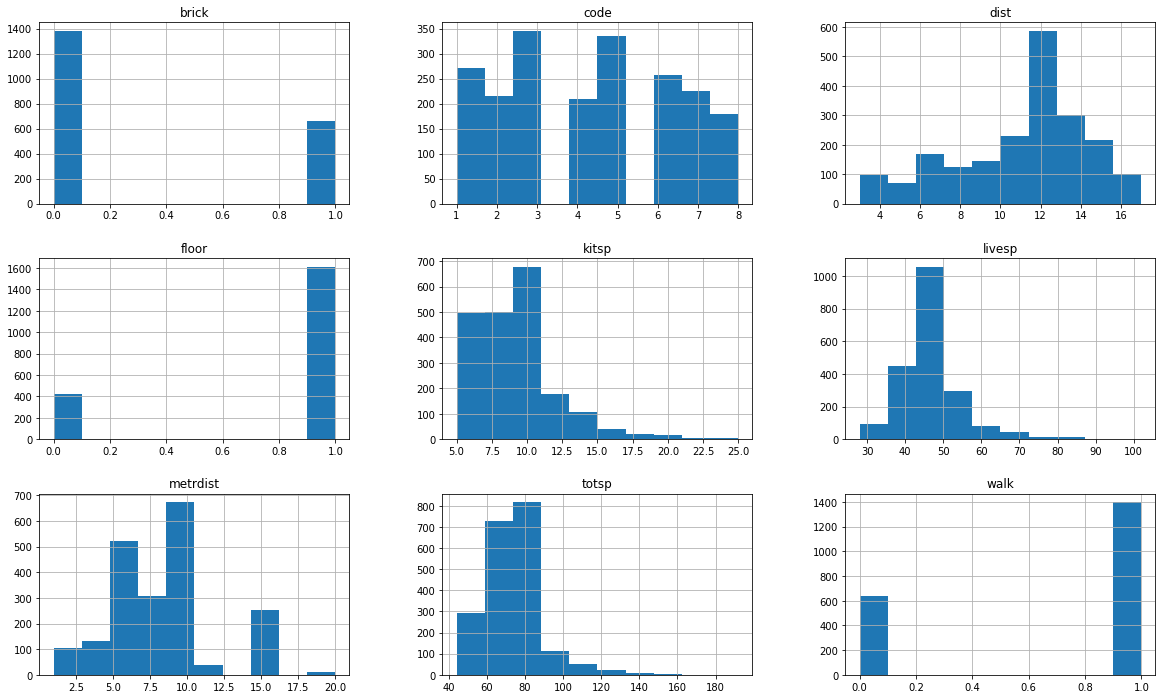

In [9]:
df.drop('price',axis=1).hist(figsize=(20, 12));

Кроме гистограммок имеет смысл взглянуть на матрицу корреляций. Что видно на ней? 

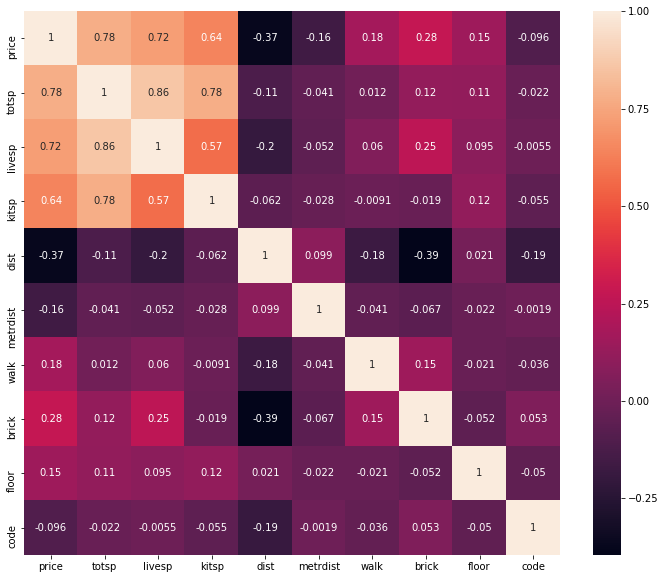

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True);

Ещё давайте посмотрим на облака рассеивания и успокоимся с картинками. 

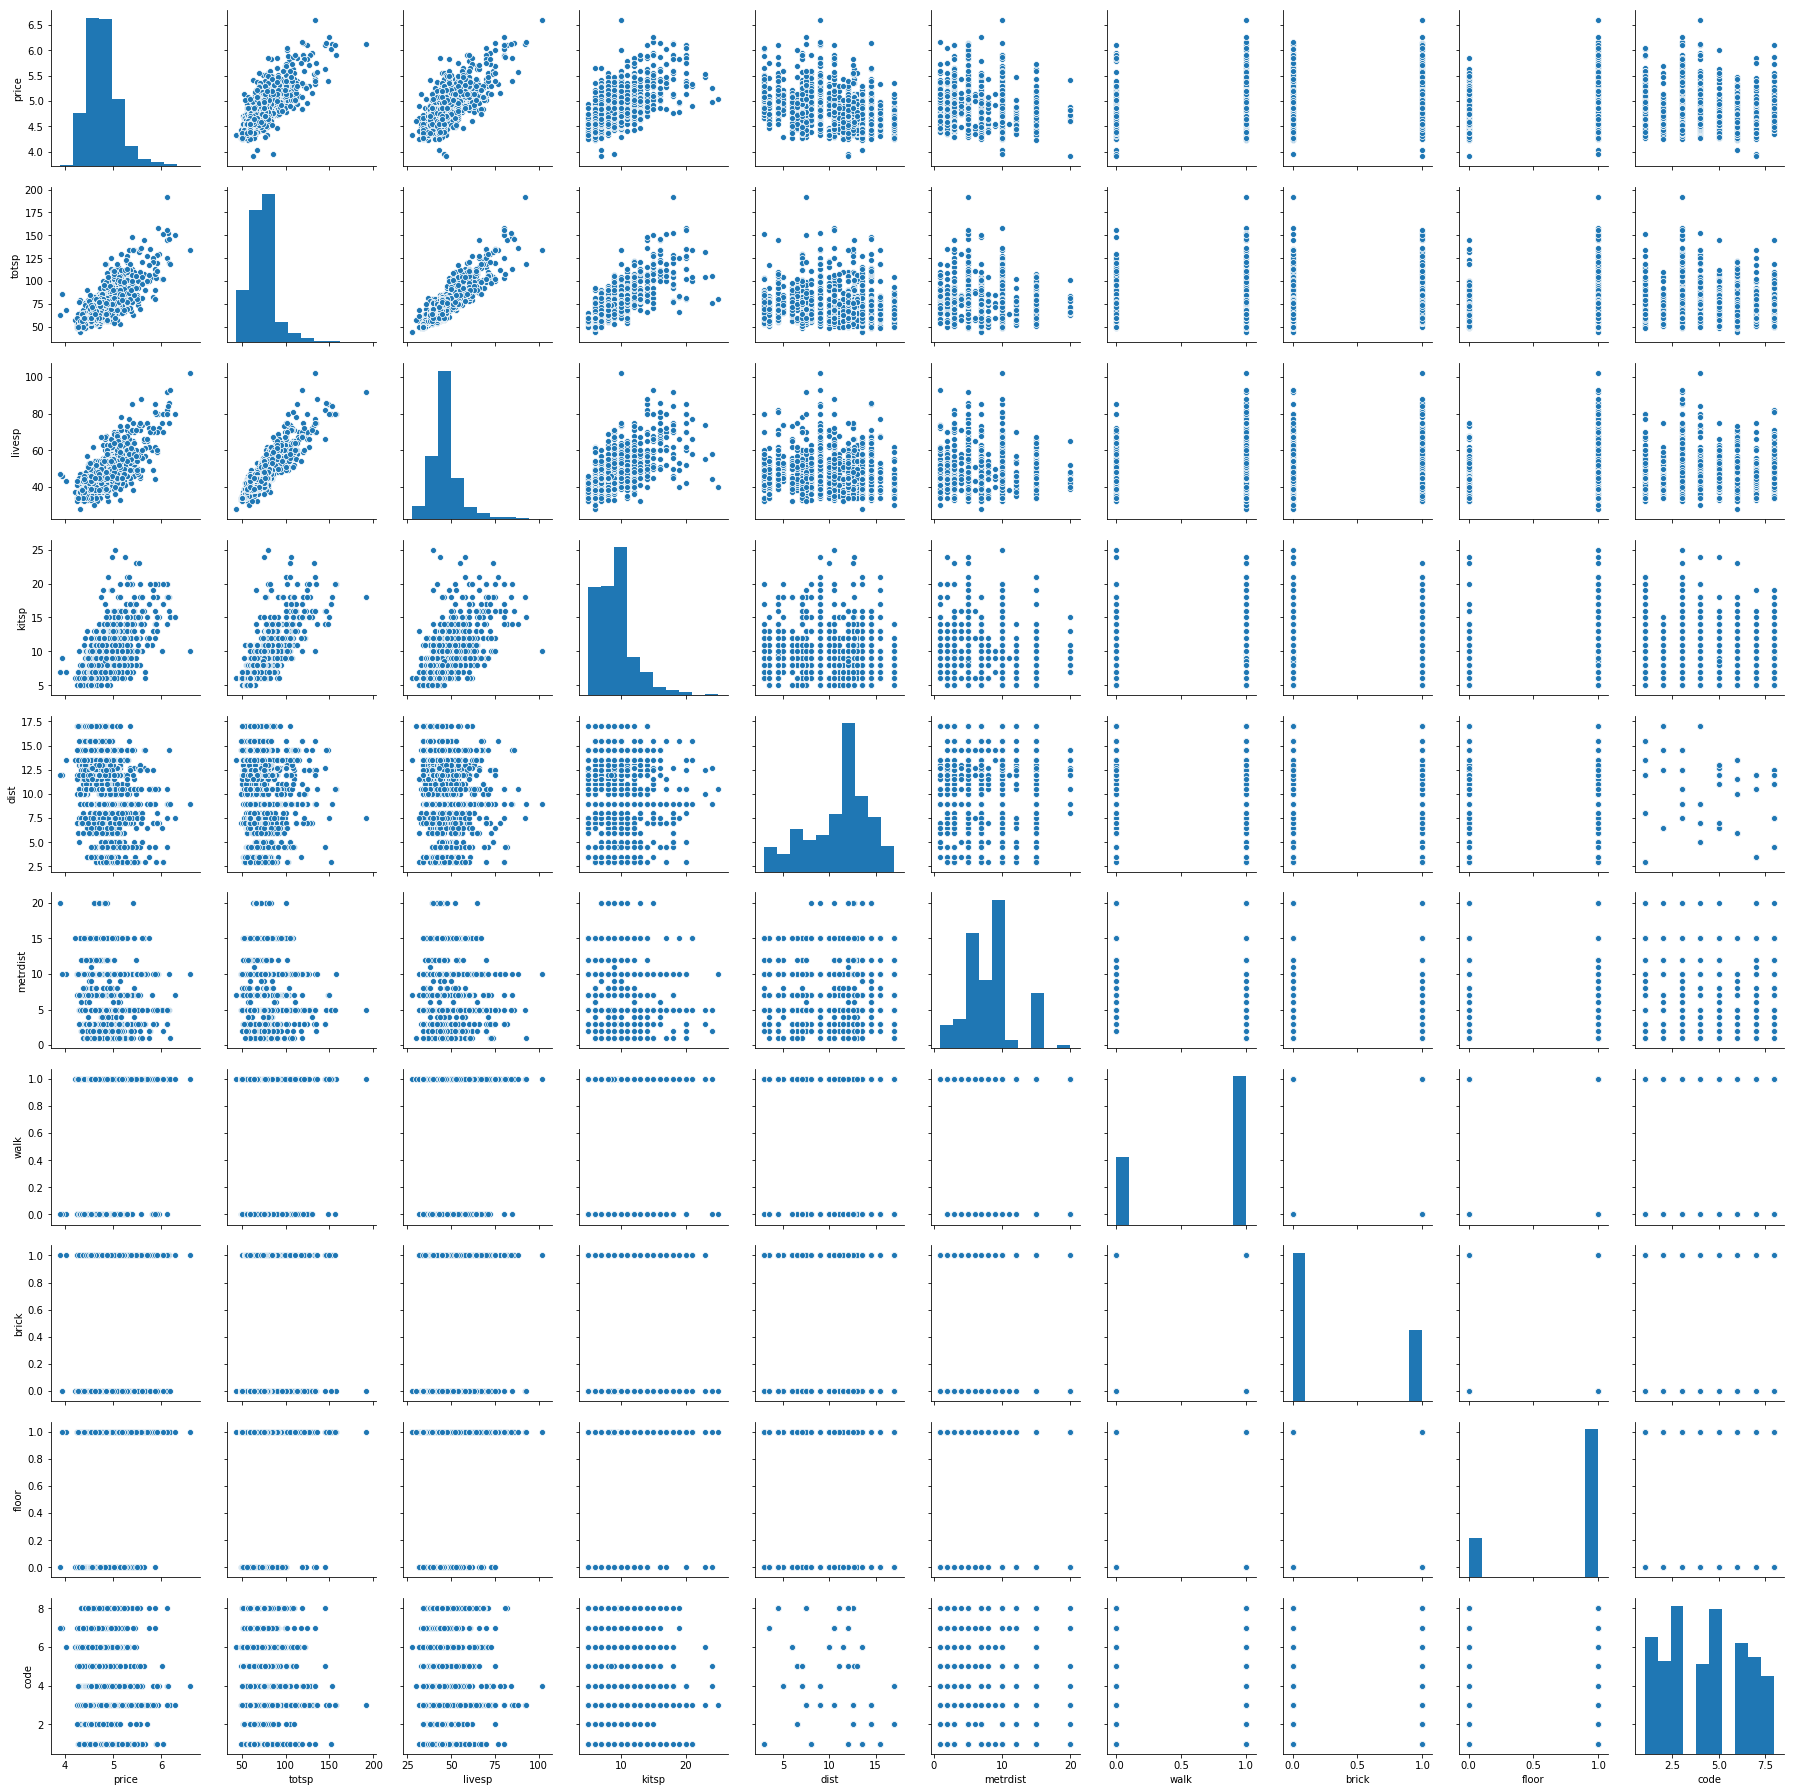

In [11]:
sns.pairplot(df)

Теперь распределение выглядит более приятно. 

Займёмся предобработкой категориальных переменных при помощи одного горячего кодирования (One Hot Encoding). При таком преобразовании категориальной переменной мы создаем столько новых столбцов, сколько различных значений этой переменной у нас было. Обычно, при этом, первый столбец убирается, чтобы не создавать линейно-зависимых столбцов. Например, если у переменной `"погода"` есть три состояния `"хорошая"`, `"средняя"` и `"нормальная"`, то после `OneHotEncoding` мы получим три столбца, где значения будут либо нулями, либо единицами, в зависимости от того, какая погода была в этом наблюдении.

## Важно
`OneHotEncoding` в общем случае тоже может привнести информацию о тестовой выборке в тренировочную в том случае, если в категориальном столбце в отложенной выборке могут содержаться новые значения. Если такая вероятность есть, то как и с другими методами препроцессинга, `OneHotEncoding` нужно обучать на трейне и использовать на тесте. 

В остальных случаях, можно воспользоваться удобной оберткой в `pandas` - `pd.get_dummies()`

In [12]:
# Сделали OHE для категориальной переменной
df_categor = pd.get_dummies(df['code'], drop_first=True, prefix='code')

# Объединили назад наши таблички
df = pd.concat([df.drop('code',axis=1),df_categor], axis=1)
df.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,,
1,4.394449,58,40,6.0,12.5,7,1,1,1,0,1,0,0,0,0,0
2,4.317488,44,28,6.0,13.5,7,1,0,1,0,0,0,0,1,0,0
3,4.852030,70,42,6.0,14.5,3,1,1,1,0,1,0,0,0,0,0
4,4.553877,61,37,6.0,13.5,7,1,0,1,0,0,0,0,0,0,0
5,5.799093,104,60,11.0,10.5,7,0,1,1,0,1,0,0,0,0,0


Делим данные на тренировочные и тестовые! $30\%$ данных откладываем для тестирования качества модели. Остальные $70\%$ берём для обучения. 

In [13]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

Последний предобрабатывательский штрих это скалирование (стандартизация непрерывных переменных). Давайте вспомним зачем его делают. Обычно, когда обучают модель, хотят минимизировать ошибку, которую она допускает. Чаще всего эту функцию минимизируют численно. Если переменные измерены в разных шкалах (что-то в тоннах, что-то в годах и тд), алгоритм может при обучении заблудиться. Хорошо бы направить его и подтолкнуть в нужном направлении. Таким толчком является стандартизация переменных. 

Из каждой переменной вычетают среднее и делят на стандартное отклонение. Это очищает переменные от своих уникальных шкал и упрощает путь алгоритма к оптимальной точке. Обычно стандартное отклонение и среднее для скалирования оценивают на обучающей выборке. К тестовой применяют уже оценённый результат. Это позволяет не подглядывать в тестовую часть и не улучшать за счёт этого подглядывания прогнозы. Подглядывать - нечестно! 

In [14]:
from sklearn.preprocessing import StandardScaler

# объявили скалировщик!
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
scaler.fit(df_train[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']]) 

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
# Применяем скалировщик к трэйну
df_train_scale = scaler.transform(df_train[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

# Применяем скалирвощик к тесту 
df_test_scale = scaler.transform(df_test[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [16]:
# Заменяем значения на отскалированные
df_train[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = df_train_scale
df_test[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = df_test_scale

Все непрерывные переменные теперь выглядят проскалированными :) 

In [17]:
df_train.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,,
1199,4.836282,0.446995,-0.047665,1.441101,1.035911,-0.799349,0,0,1,0,1,0,0,0,0,0
1599,5.075174,-1.041660,-0.549995,-0.318985,-2.259234,-0.799349,1,1,1,0,0,0,0,0,1,0
966,4.787492,-0.588591,-0.424412,-0.671002,-0.611662,-0.799349,0,0,1,0,0,1,0,0,0,0
1117,4.828314,0.188099,0.077917,0.737067,-0.012545,-0.272597,1,0,1,0,0,0,1,0,0,0
717,4.912655,0.317547,0.203500,0.033032,0.436793,1.834407,1,0,1,1,0,0,0,0,0,0


In [18]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape)  

(1428, 16)
(612, 16)


In [19]:
# Вытаскиваем цены и параметры квартир по разным переменным для удобства 

y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1).get_values()
X_test = df_test.drop('price', axis=1).get_values()

## 2. Константный прогноз 

Шаг первый. Построим константный прогноз. Будем говорить, что стоимость любой квартиры равна среднему значению. Это самый глупый прогноз, который мы можем сделать. Мы будм сравнивать с ним прогнозы более сложных моделей. 

In [24]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]

array([4.79717219, 4.79717219, 4.79717219, 4.79717219, 4.79717219])

## 3. Метрики качества для регрессии 

Мы сделали выше прогноз. Теперь мы хотим понять насколько он хороший. Для этого обычно используют метрики. Посмотрим на несколько таких метрик. 

In [26]:
from sklearn import metrics  # подгружаем метрики

Первой метрикой, с которой мы познакомимся, будет MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что квартира стоит 20 рублей, а она стоила 10 рублей, мы ошиблись на |10 - 20| = 10 рублей. Средняя абсолютная ошибка - это средняя сумма рублей, на которую мы облажались. 

In [27]:
metrics.mean_absolute_error(y_test, y_pred_naive)

0.22965688475729693

Напомню, что мы прогнозируем логарифм цены, нам так удобнее. Ошибка выше считается в логарифмах. Если мы хотим посмотреть на ошибку в долларах, надо взять экспоненту от цен. Ниже мы можем увидеть, что в среднем ошибаемся на тридцать с лишним тысяч долларов. 

In [28]:
metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred_naive))

29.718524453159713

Второй метрикой является MSE (mean squared error), средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 долларов, то в ошибку войдёт 25. Если мы ошиблись на 10 долларов, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

In [29]:
metrics.mean_squared_error(y_test, y_pred_naive)

0.08643813158542085

По аналогии перейдём к долларам. 

In [30]:
metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive))

2097.212846991979

Получилось многовато, не находите? Всё дело в том, что это не просто доллары, это квадратные доллары. Мы же суммировали квадраты. Неплохо было бы вернутся к обычным долларам. Для этого надо взять из MSE квадратный корень. Тогда получится новая ошибка, RMSE. 

In [42]:
np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive)))

55.03247101217138

Ошибка в среднем более чем на 60 тысяч долларов. Так как более большие ошибки входят с более большим весом, вполне логично, что RMSE получилось больше, чем MAE. 

Часто для нас принципиальным является не то, на сколько денег мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

Её нам придётся реальзовать самостоятельно. Благо, это не очень трудно. 

In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred_naive)

4.772965278694697

Средняя ошибка примерно на $5\%$ от цены. 

Последняя метрика, с которой нам нужно познакомиться, это коэффициент детерминации, $R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$

Эту метрику очень сильно любят консалтеры и аудиторы, потому что только её они и знают. На самом деле в ней нет ничего хорошего. При добавлении в модель новых переменных она всегда растёт. У неё есть ещё несколько тонких математических недостатков, о которых вы можете узнать из книг. 

In [33]:
metrics.r2_score(y_test, y_pred_naive)

-0.004339044284300986

Закинем все метрики в одну общую функцию, чтобы было удобно их печатать. 

In [38]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [39]:
print_metrics(y_test, y_pred_naive)

MAE: 29.718524453159713
RMSE: 45.79533652013029
R2: -0.004339044284300986
MAPE: 4.772965278694697


## 3. Строим нашу первую регрессию!

Пришло время построить линейную регрессию! Эта модель говорит, что цена на квартиру формируется в результате суммирования тех характеристик, которыми она обладает с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ price = 10000 + 20 \cdot totsp,$$

то это означает, что средняя стоимость квартиры равна 10 тыс. долларам. При этом каждый дополнительный метр общей площади квартиры делает её дороже на 20 рублей. 

Для того, чтобы обучить регрессию минимизируют одну из метрик, перечисленных в прошлом разделе. В базовой комплектации регрессии это делают с MSE. Такая модель обладает огромным количеством няшных статистических свойств. 

In [40]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на качество прогнозов. Мы стали ошибаться меньше, чем раньше. 

In [41]:
print_metrics(y_test,y_pred_regr)

MAE: 14.966222557274383
RMSE: 23.788767120202795
R2: 0.751803290483054
MAPE: 2.2507206980004772


Посмотрим на то, какие признаки вносят в цену наибольший вклад. 

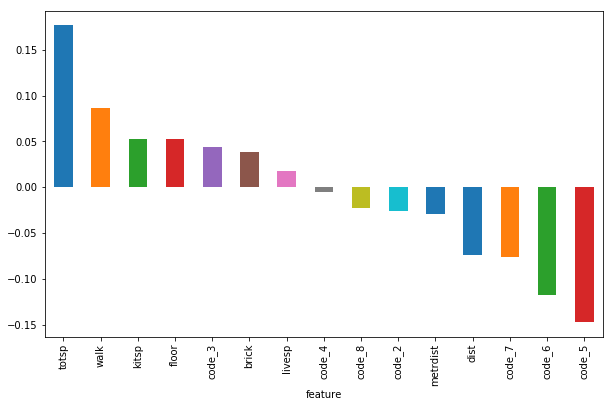

In [43]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

## 4. Строим Lasso-регрессию 

Построим более сложную модель, LASSO-регрейссию. Фишка этой модели в том, что она зануляет лишние коэффиценты. 

In [44]:
from sklearn.linear_model import Lasso

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

Посмотрим на важность факторов для стоимости квартиры. 

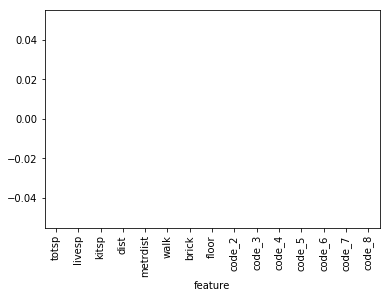

In [45]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_simplelasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

In [46]:
print_metrics(y_test,y_pred_lasso)

MAE: 29.71852445315995
RMSE: 45.795336520130185
R2: -0.004339044284305649
MAPE: 4.772965278694748


Важных факторов нет, всё занулилось. Метрики качества такие же, как при константном прогнозе. Почему такое произошло? Дело в том, что у модели есть гиперпараметр - сила зануления. И его нужно подбирать методом перебора. В нашей модели он стоял слишком большим. Давайте попробуем подобрать этот параметр. 

## 5. Подбор гиперпараметра для Lasso-регрессии

Будем делать перебор следующим способом: дробим тренировочную выборку на пять частей. На четырёх учим модель, на пятой прогнозируем. Смотрим на качество. И так по очереди выделяем для прогноза каждую из 5 частичек. Потом качество прогноза усредняем - кросс-валидация. Для какого параметра из решётки качетство получится наибольшим, тот мы и оставим. 

In [47]:
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


При параметре 0.001 качество у прогнозов получилось самым хорошим. Его и берём. Посмотрим на важность переменных

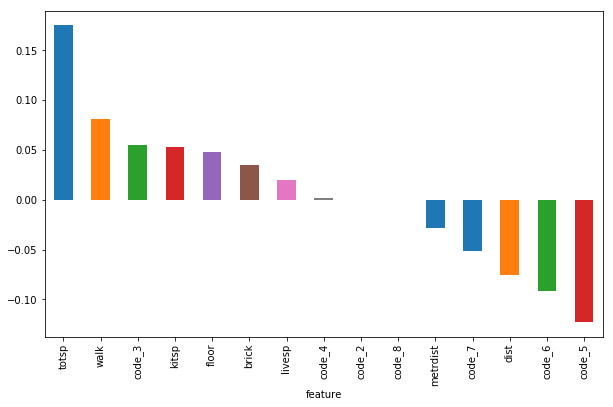

In [48]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

И на качество модели. Оно оказывается близким к обычной регрессии. Судя по всему у нас в выборке нет лишних переменных и занулять нечего. 

In [49]:
print_metrics(y_test,y_pred_lasso)

MAE: 15.121064740609143
RMSE: 23.893718080124902
R2: 0.7485459907124927
MAPE: 2.2771411063268676


In [50]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.0003858300347722622


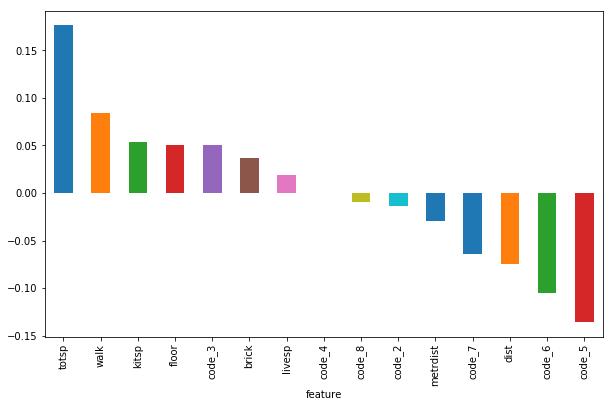

In [51]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

In [52]:
print_metrics(y_test, y_pred_lasso_cv)

MAE: 15.019361944056548
RMSE: 23.824484954341226
R2: 0.7508235654350641
MAPE: 2.2595034098937856
